In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline

In [2]:
def generate_data(init, end, num_points, plot=1):
    """
    
    x_pts : 1-d array, shape = [num_points,]     
    y_pts : 1-d array, shape = [num_points,]

    """
    #declare a list of coefficients 
    coeff=[5,1,1]
    noise=2
    # generate x_coordinate of line
    x = np.arange(init,end,(end-init)/num_points)
    line = coeff[0]
    #generate y_coordinates of line
    for idx in np.arange(1, len(coeff)):
        line += coeff[idx]*x**idx
        if noise>0:
            y= np.random.normal(-(10**noise), 10**noise, len(x))+line
        else: y= line
    if plot==1:
        plt.figure(figsize=(10,6))
        plt.scatter(x, y, color='r')
        plt.xlabel('x')
        plt.ylabel('y')
        
    return x, y

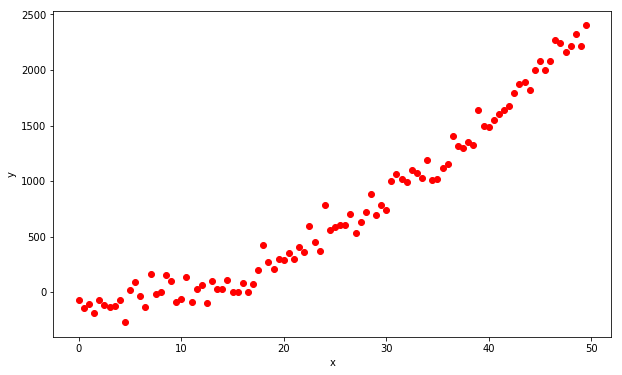

In [3]:
x,y=generate_data(0,50,100)

In [4]:
def hypothesis(x, theta):
    """
    h(x) = theta_0*(x_1**0) + theta_1*(x_1**1) + ...+ theta_n*(x_1 ** n)
    
    """
    h = theta[0]
    for i in np.arange(1,len(theta)):
        h+= theta[i]*x**i
    
    return h

In [5]:
# Calculate inverse of matrix using Doolittle’s LU Decomposition Method

def swapRows( M,i,j):
    """
    Swaping:
    ----------
    swapRows(M,i,j).
    Swaps rows i and j of a vector or matrix [v].
        
    """
    if len(M.shape) == 1:
        M[i],M[j] = M[j],M[i]
    else:
        M[[i,j],:] = M[[j,i],:]
        
def swapCols(M,i,j):
    """
    Swaping:
    ----------
    swapCols(M,i,j).
    Swaps columns of matrix [M].
        
    """
    M[:,[i,j]] = M[:,[j,i]]
    
def LUdecomp(a,tol=1.0e-9):
    n = len(a)
    seq = np.array(range(n))
    
    # Set up scale factors
    s = np.zeros((n))
    for i in range(n):
        s[i] = max(abs(a[i,:]))
        
    for k in range(0,n-1):
        # Row interchange, if needed
        p = np.argmax(np.abs(a[k:n,k])/s[k:n]) + k
        if abs(a[p,k]) < tol: print('Matrix is singular')
        if p != k:
            swapRows(s,k,p)
            swapRows(a,k,p)
            swapRows(seq,k,p)
        # Elimination
        for i in range(k+1,n):
            if a[i,k] != 0.0:
                lam = a[i,k]/a[k,k]
                a[i,k+1:n] = a[i,k+1:n] - lam*a[k,k+1:n]
                a[i,k] = lam
    return a, seq


def LUsolve(a,b,seq):
    """
    Solve Linear equations
    -------------
    x = LUsolve(a,b)
    Solution phase: solves [L][U]{x} = {b}
        
    """
    n = len(a)
    # Rearrange constant vector; store it in [x]
    x = b.copy()
    for i in range(n):
        #print(seq[i])
        x[i] = b[seq[i]]
    # Solution
    for k in range(1,n):
        x[k] = x[k] - np.dot(a[k,0:k],x[0:k])
    x[n-1] = x[n-1]/a[n-1,n-1]
    for k in range(n-2,-1,-1):
        x[k] = (x[k] - np.dot(a[k,k+1:n],x[k+1:n]))/a[k,k]
    return x
    
def matInv(a):
    """
    Calacute inverse of matrix a:
    ----------------------------
    input matrix:a
    retrun: aInv
        
    """
    n = len(a[0])
    aInv = np.identity(n)
    a,seq = LUdecomp(a)
    for i in range(n):
        aInv[:,i] = LUsolve(a,aInv[:,i],seq)
    return aInv


In [6]:
def calculate_error(theta, x, y):
        
        m = len(y)  
        h = hypothesis(x, theta)
        errors = h-y
        
        return (1/(2*m))*np.sum(errors**2) 
    

In [7]:
def print_line(theta):
    
    fit_line=''
    fit_line = fit_line+str(theta[0])
    for i in np.arange(1, len(theta)): 
            
        fit_line = fit_line+' + ' + str(theta[i]) + r'x^' + str(i)  
        
    print("Fitting Line::::",fit_line)

In [8]:
#fit curve using normal equation method

def fit_NormalEq(lamda, order, x,y):
        
    """
    
    Fit theta to the training data to the model of the form:
        h(x) = theta_0*(x_1**0) + theta_1*(x_1**1) + ...+ theta_n*(x_1 ** n)
        
    """
    d = {}
    d['x' + str(0)] = np.ones([1,len(x)])[0]    
    
    for i in np.arange(1, order+1):                
        d['x' + str(i)] = x ** (i)        
        
    d = OrderedDict(sorted(d.items(), key=lambda t: t[0]))
    X = np.column_stack(d.values())  
    print('X matrix dimension', X.shape)
    I = np.eye(order+1)*lamda*order
    
    theta = np.matmul(np.matmul(matInv(np.matmul(np.transpose(X),X)+I), np.transpose(X)), y)

               
    return theta
    

In [9]:
def fit_newtonMT(lamda,order,x,y):
    
    theta = np.ones(order+1)
    
    d={}
    d['x'+str(0)]= np.ones([1,len(x)])[0]
    
    for i in range(1,order+1):
        
        d['x'+str(i)]= x**i
        
    d= OrderedDict(sorted(d.items(),key=lambda t :t[0]))
    X = np.column_stack(d.values())  
    I = np.eye(order+1)*lamda
    
    while True:
        a = matInv(np.matmul(np.transpose(X),X) + I)
        b = np.matmul(np.matmul(np.transpose(X),X),theta) 
        c = np.matmul(np.transpose(X),y)
        d = np.matmul(I,theta)
        
        new_theta = theta - np.matmul(a,(b - c + d))
        
        if abs(calculate_error(new_theta, x, y) - calculate_error(theta, x, y)) < 0.0001:
            break
        theta = new_theta
        
    return new_theta

In [10]:
def plot_predictedPolyLine(theta,x,y):
        
    plt.figure(figsize=(10,6))
    plt.scatter(x, y, s = 30, c = 'r') 
    line = theta[0] #y-intercept 
    label_holder = []
    label_holder.append('%.*f' % (2, theta[0]))
    
    for i in np.arange(1, len(theta)):            
        line += theta[i] * x ** i 
        label_holder.append(' + ' +'%.*f' % (2, theta[i]) + r'$x^' + str(i) + '$') 
        
    plt.plot(x, line, label = ''.join(label_holder), color='g')        
    plt.title('Polynomial Fit: Order ' + str(len(theta)-1))
    plt.xlabel('x')
    plt.ylabel('y') 
    plt.legend(loc = 'best')   

In [17]:
print("*******Demo of Polynomial Regression********")
print("  ")
order = input("Input the number of polynomial bases:  ")
order = int(order)
lamda = input("Input the lambda value for regularization:  ")
lamda = float(lamda)
print("------------------------")
print("  ")
theta = fit_newtonMT(lamda,order,x,y)
error = calculate_error(theta,x,y)
print("Newton Method:")
print_line(theta)
print(" ")
print("Prediction error:", error)
print("------------------------")

*******Demo of Polynomial Regression********
  
Input the number of polynomial bases:  3
Input the lambda value for regularization:  2000
------------------------
  
Newton Method:
Fitting Line:::: -1.0746515226140465 + -5.016256642486181x^1 + 1.0690839474559475x^2 + 0.000527393044792399x^3
 
Prediction error: 5248.363742597884
------------------------


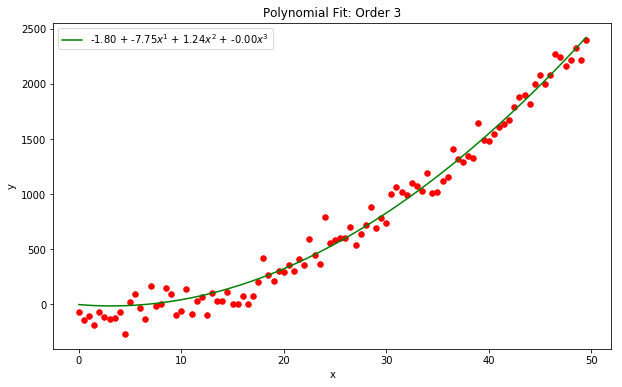

In [16]:
plot_predictedPolyLine(theta,x,y)

In [13]:
print("*******Demo of Polynomial Regression********")
print("  ")
order = input("Input the number of polynomial bases:  ")
order = int(order)
lamda = input("Input the lambda value for regularization:  ")
lamda = float(lamda)
print("------------------------")
print("  ")
theta = fit_NormalEq(lamda,order,x,y)
error = calculate_error(theta,x,y)
print("LSE:")
print_line(theta)
print(" ")
print("Prediction error:", error)
print("------------------------")

*******Demo of Polynomial Regression********
  
Input the number of polynomial bases:  3
Input the lambda value for regularization:  1000
------------------------
  
X matrix dimension (100, 4)
LSE:
Fitting Line:::: -0.7724202120420749 + -3.7000393735023778x^1 + 0.9885462946497136x^2 + 0.001667270622619397x^3
 
Prediction error: 5396.244300121354
------------------------


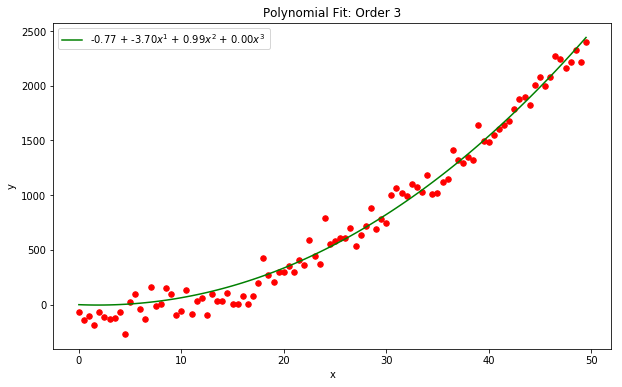

In [14]:
plot_predictedPolyLine(theta,x,y)